## ISM機能階層分析

#### ライブラリのインポート

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

#### 機能項目相互間の関係のマトリックス宣言

In [3]:
start_column = 7    # マトリックスの開始列（G列）
start_row = 5       # マトリックスの開始行（5行）
num = 22            # 読み取るセルの範囲（num 行の正方形を読み取る）

In [4]:
# 階層構造を定義した2次元マトリックスを取得する関数
def read_data(start_row, start_column, num):
    df = pd.read_excel("機能項目相互間の関係ver.2.xlsx", header=None, sheet_name="性能・性質", 
                       skiprows=start_row - 1, nrows=num, usecols=range(start_column - 1, start_column - 1 + num))
    
    data = np.where(df.values == "○", 1, 0)

    return data

# データを読み取る
matrix = read_data(start_row, start_column, num)
print('---------- 入力データ ----------')
print(matrix)

---------- 入力データ ----------
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

#### 各種関数の定義

In [5]:
# ISM機能階層分析を行う関数
def reachability_matrix(matrix):

    ###----------可達行列作成処理----------###
    # 行列のサイズを取得
    n = len(matrix)

    print('\n----------隣接行列----------')
    matrix = matrix.astype(bool)
    I = np.eye(n).astype(bool)
    adj_matrix = np.logical_or(matrix, I)
    print(adj_matrix.astype(int))

    print('\n----------可達行列----------')
    reachability_matrix = adj_matrix.copy()
    while not np.array_equal(reachability_matrix, reachability_matrix @ adj_matrix):
        reachability_matrix = reachability_matrix @ adj_matrix  #@演算子を利用することで行列積を求める（bool演算）
    print(reachability_matrix.astype(int))

    return reachability_matrix

In [6]:
# ノードの配置を取得する関数
def get_layer_positions(removed_rows_dict, custom_pos={}):
    positions = {}
    current_x = 0
    for layer, nodes in removed_rows_dict.items():
        for node in nodes:
            positions[node] = (current_x, -layer)
            current_x += 1
        current_x = 0

    # custom_posで指定したノード番号のx座標を辞書リストに追加する
    for node, x_coord in custom_pos.items():
        positions[node] = (x_coord, positions[node][1])

    return positions

# グラフオブジェクトを作成する関数
def create_graph(removed_rows_dict):
    G = nx.DiGraph()

    # ノードをグラフに追加
    for i in range(matrix.shape[0]):
        G.add_node(i)

    # matrixを参照しエッジを追加する関数
    def add_edges(source_node, target_nodes, target_layer_dict):
        sorted_target_nodes = sorted(target_nodes, key=lambda node: target_layer_dict[node], reverse=True)
        for target_node in sorted_target_nodes:
            if source_node != target_node and not nx.has_path(G, source_node, target_node) and not nx.has_path(G, target_node, source_node):
                G.add_edge(source_node, target_node)
                print('Edge added:', source_node, '->' , target_node)

    sorted_removed_rows_dict = dict(sorted(removed_rows_dict.items()))  # 階層を昇順にソート

    # target_nodeが属する階層の情報を辞書リストとして取得
    target_layer_dict = {}
    for layer, nodes in removed_rows_dict.items():
        for node in nodes:
            target_layer_dict[node] = layer
    
    print('\n--------エッジ追加処理--------')
    for layer, nodes in sorted_removed_rows_dict.items():
        target_nodes = []
        for node in nodes:
            target_nodes = matrix[node].nonzero()[0]
            add_edges(node, target_nodes, target_layer_dict)
    
    return G

In [7]:
# R, A列を取得する関数
def get_RorA(reachability_matrix):
    R_or_A = []
    for i in range(len(reachability_matrix)):
        temp = []
        for j in range(len(reachability_matrix[i])):
            if reachability_matrix[i][j] == 1:
                temp.append(j)
        R_or_A.append(temp)
    return R_or_A

# 重複する要素を抽出する関数
def extract_duplicates(list1, list2):
    # 各リスト内の各サブリストの集合を作成
    set_a = [set(sublist) for sublist in list1]
    set_b = [set(sublist) for sublist in list2]

    # 各リスト内で同じ位置にあるサブリストから重複する要素を抽出
    duplicates = [list(set_a[i] & set_b[i]) for i in range(min(len(set_a), len(set_b)))]

    return duplicates

# 特定の数字を除去する関数
def remove_number(lst, num):
    return [x for x in lst if x != num]

# 新しいデータフレームを取得する関数
def get_new_df(df, i, removed_rows_dict):
    remove_idx = []
    remove_id = []
    remove_num = []
    for j in range(len(df)):
        if df['R'][j] == df['RandA'][j]:
            remove_idx.append(j)
            remove_id.append(df['id'][j])
            for num in df['R'][j]:
                remove_num.append(num)

    remove_idx, remove_num
    # print('remove_idx:', remove_idx)
    # print('remove_num:', remove_num)
    removed_rows_dict[i] = remove_id

    # dfを更新
    df = df.drop(remove_idx)

    # 特定の数字をリスト内からすべて除去する
    for num in remove_num:
        to_remove = num
        # print(num)
        # df = df.applymap(lambda x: [elem for elem in x if elem != to_remove])
        # df = df.applymap(lambda x: remove_number(x, to_remove))
        df['R'] = df['R'].apply(lambda x: remove_number(x, to_remove))
        df['A'] = df['A'].apply(lambda x: remove_number(x, to_remove))
        df['RandA'] = df['RandA'].apply(lambda x: remove_number(x, to_remove))

    return df.reset_index(drop=True), removed_rows_dict

#### ISM機能階層分析 と 階層グラフの作成

In [8]:
# 可達行列導出
reachability_matrix = reachability_matrix(matrix)
reachability_matrix = reachability_matrix.astype(int)


----------隣接行列----------
[[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [32]:
# 関与度取得
row_sums = np.sum(reachability_matrix, axis=1)    # ISM
# row_sums = np.sum(matrix, axis=1)   # dematel
# # 各行の和を表示
# for i, row_sum in enumerate(row_sums):
#     print(f"行 {i + 1} の和: {row_sum}")

# row_sums

# 各列の和を計算
# column_sums = np.sum(reachability_matrix, axis=0) # ISM
column_sums = np.sum(matrix, axis=0)    # dematel

# # 各列の和を表示
# for j, column_sum in enumerate(column_sums):
#     print(f"列 {j + 1} の和: {column_sum}")

# 関連度
d_add_r = row_sums + column_sums
d_add_r

array([14, 15,  5,  6,  7,  7,  3,  3,  3,  6,  7,  6,  3,  7,  3,  6,  7,
       10,  9,  9,  4, 11])

In [37]:
custom_pos = {}
for i in range(len(matrix)):
    custom_pos[i] = d_add_r[i]

In [10]:
# データフレーム作成
R = []
A = []
id = list(range(len(reachability_matrix)))

R = get_RorA(reachability_matrix)
A = get_RorA(np.transpose(reachability_matrix))
RandA = extract_duplicates(R, A)

for RandA_i in RandA:
    RandA_i.sort()

df = pd.DataFrame({'id':id, 'R':R, 'A':A, 'RandA':RandA})

In [11]:
# 階層を取得
levels = {}
c = 0
initial_df_length = len(df)

for i in range(len(df)):
    df, levels = get_new_df(df, i+1, levels)
    # print('len(lebels): ', len(levels[i+1]))
    c += len(levels[i+1])
    # print('c: ', c)

    if c == initial_df_length:
        break

print('levels:\n', levels)

levels:
 {1: [1, 14], 2: [0, 7], 3: [2, 6, 8, 10, 12, 20], 4: [9, 11], 5: [3, 13, 18], 6: [5, 15, 16, 19], 7: [4, 17, 21]}



--------エッジ追加処理--------
Edge added: 0 -> 1
Edge added: 7 -> 1
Edge added: 2 -> 0
Edge added: 6 -> 7
Edge added: 8 -> 0
Edge added: 10 -> 0
Edge added: 12 -> 0
Edge added: 20 -> 0
Edge added: 9 -> 2
Edge added: 11 -> 10
Edge added: 3 -> 9
Edge added: 13 -> 11
Edge added: 18 -> 11
Edge added: 5 -> 13
Edge added: 15 -> 18
Edge added: 16 -> 3
Edge added: 19 -> 18
Edge added: 19 -> 2
Edge added: 19 -> 20
Edge added: 4 -> 5
Edge added: 17 -> 19
Edge added: 17 -> 14
Edge added: 21 -> 16
Edge added: 21 -> 18
Edge added: 21 -> 14


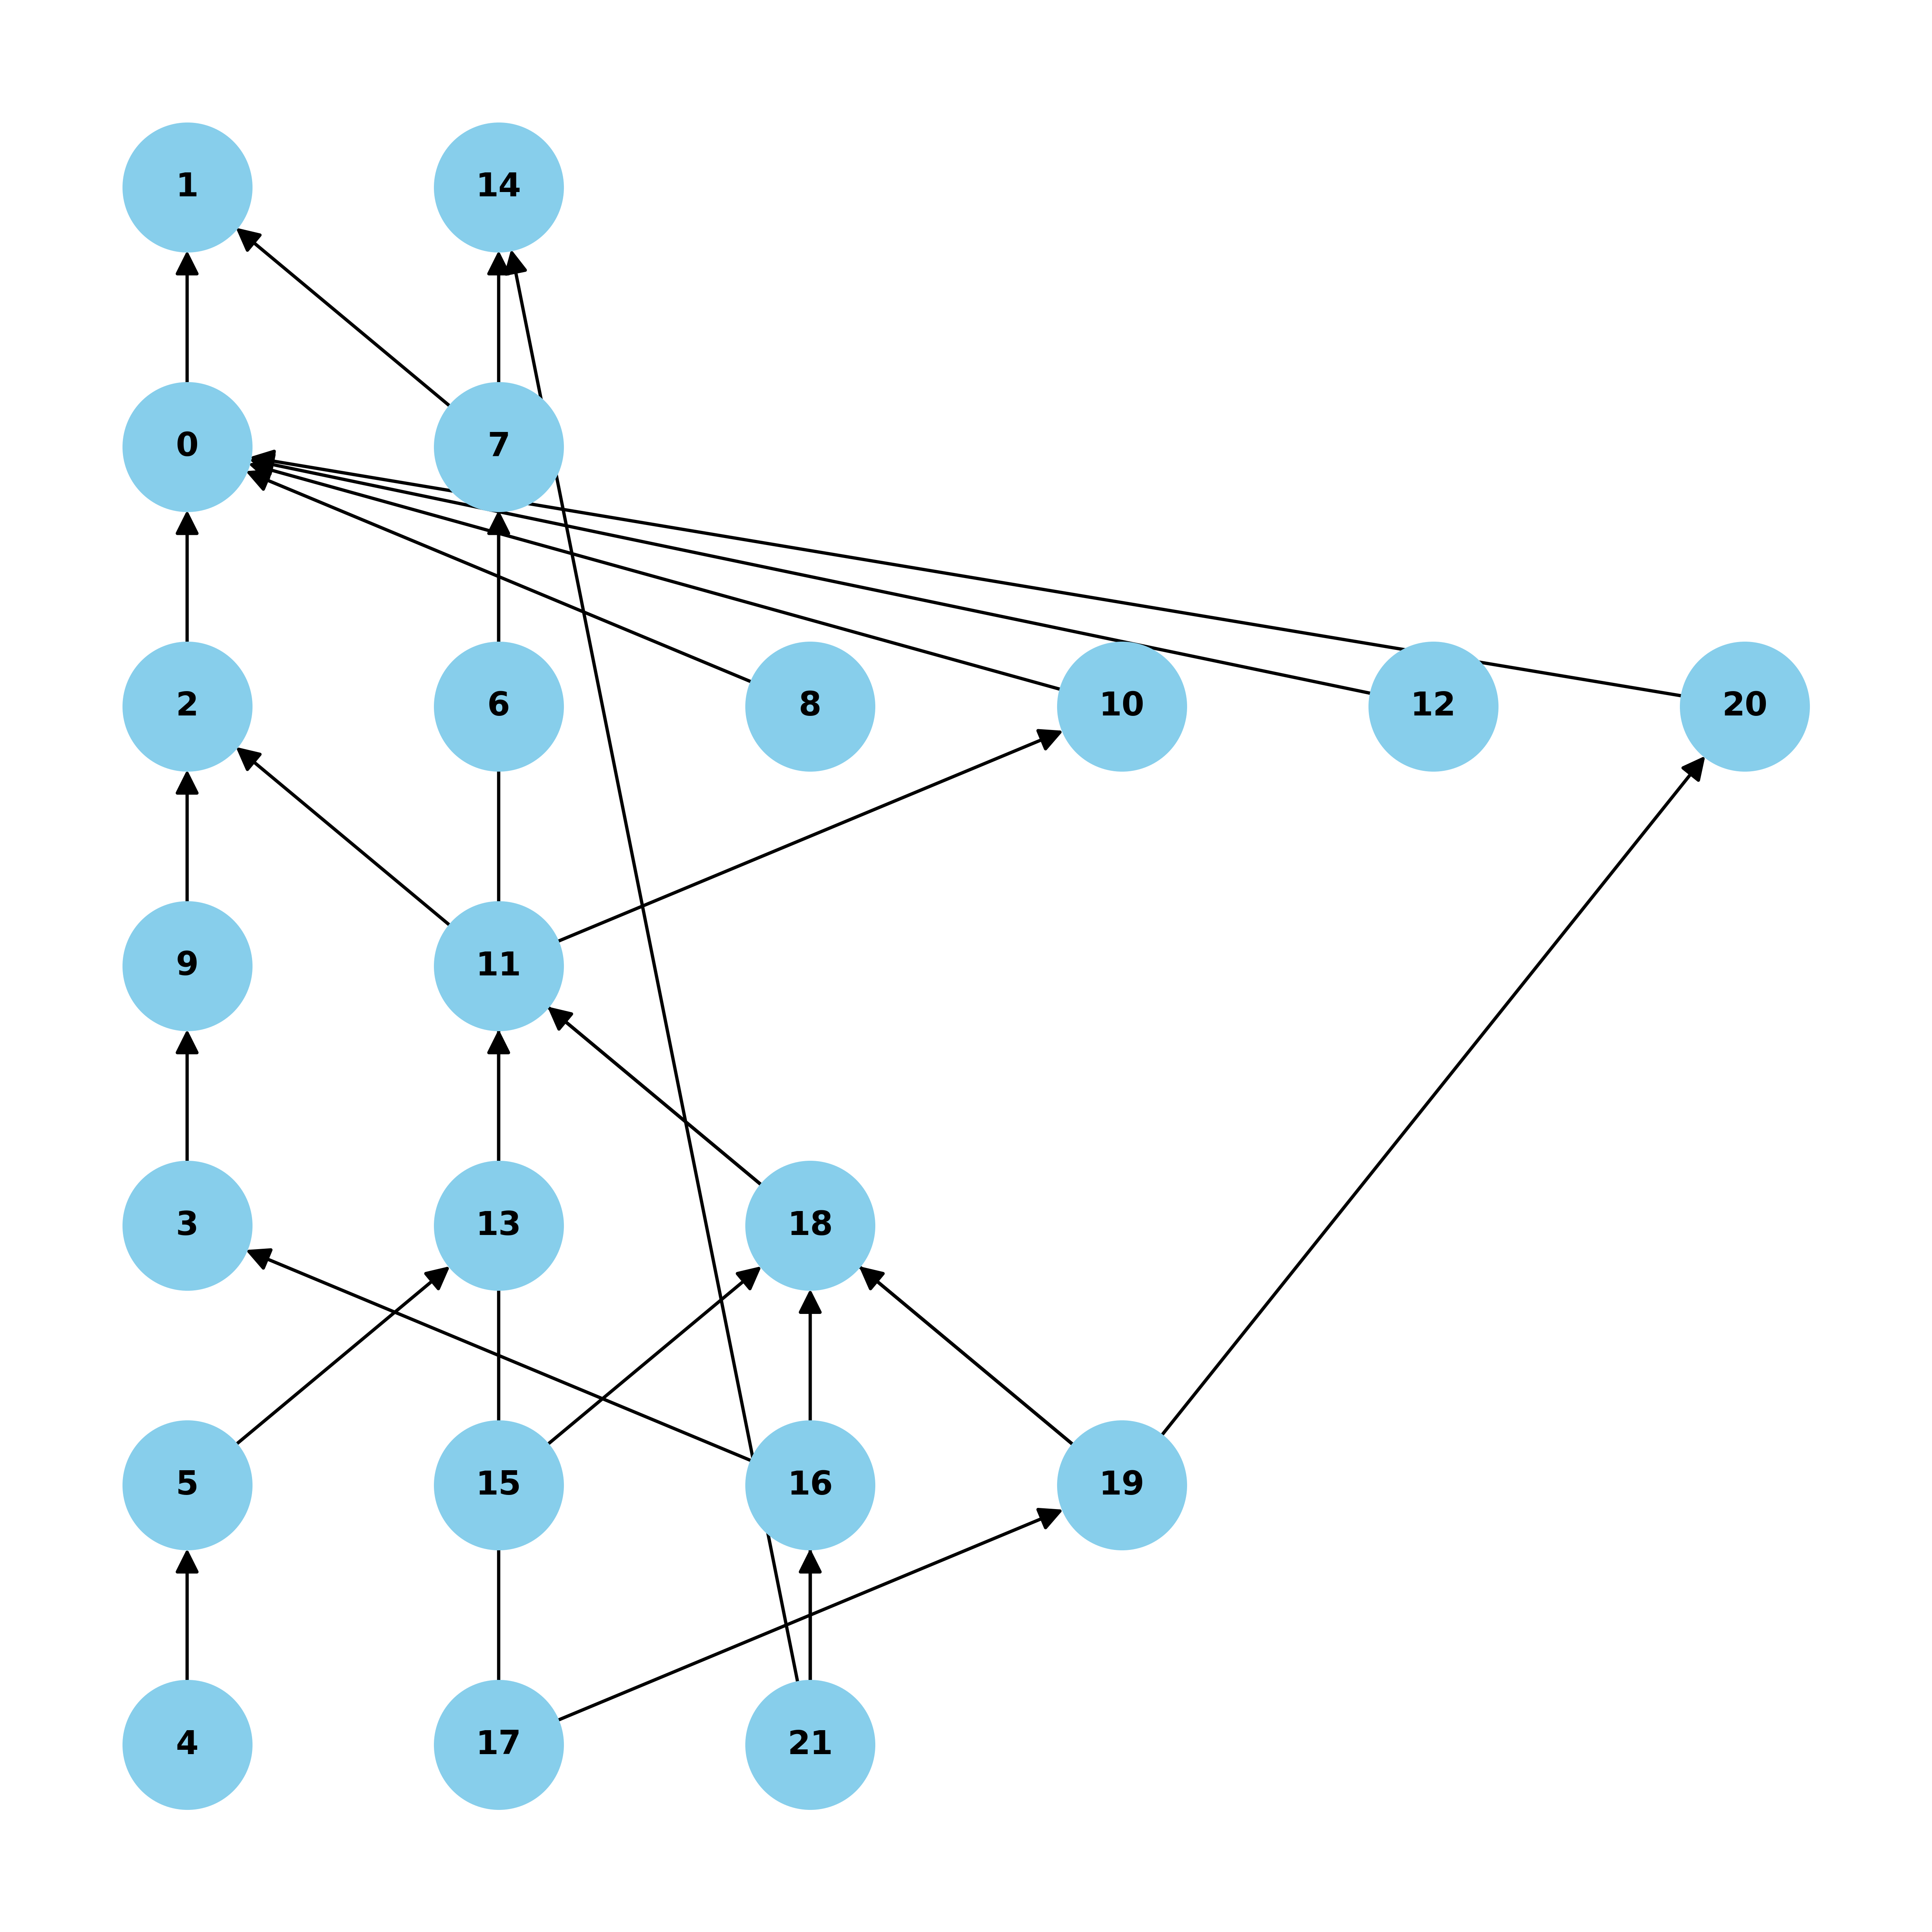

In [12]:
# グラフを作成
G = create_graph(levels)

# ノードの配置を取得
pos = get_layer_positions(levels)

# グラフを描画して表示
plt.figure(figsize=(8, 8), dpi=600)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=15)
plt.savefig('fig\ISM-FHA_exercise.png', format='png')
plt.show()

ノードの位置を調節  
- エッジが重なって表示されているところがあるため  
- 見やすくなるようにするため  

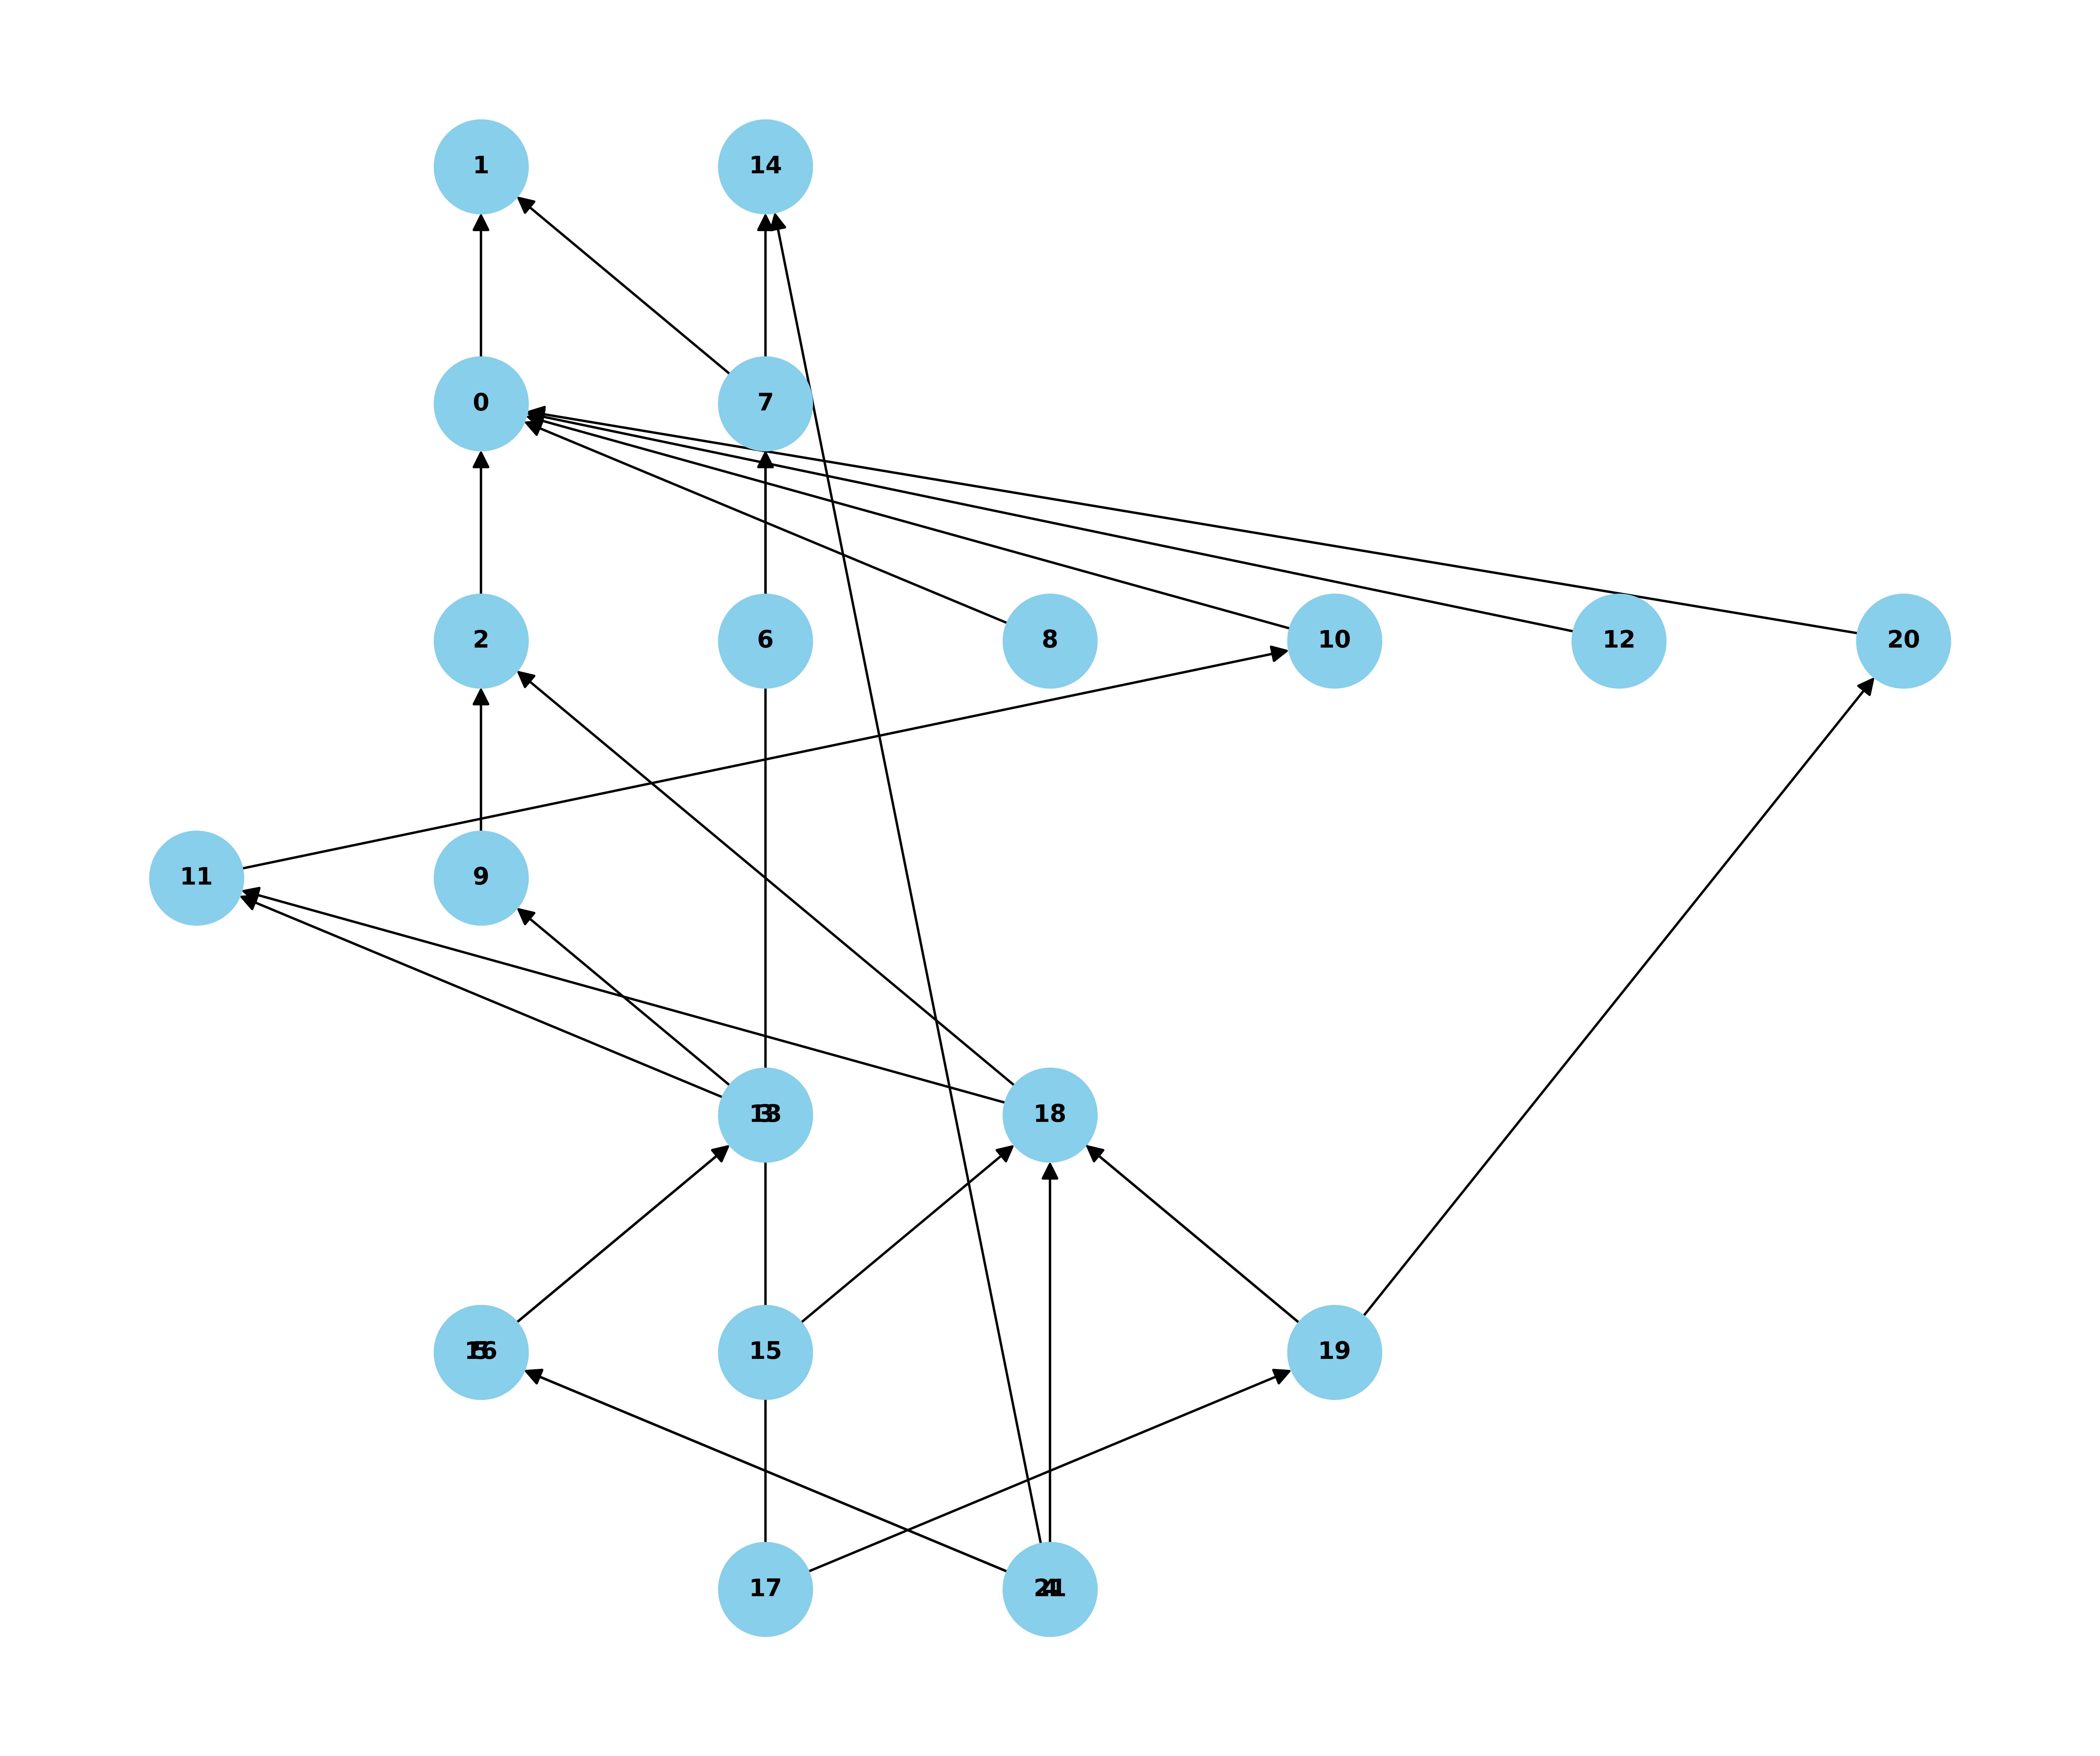

In [13]:
# custom_posでノード番号に対応するx座標を指定する
custom_pos = {3 : 1, 
              4 : 2,
              11: -1,
              16: 0}

# ノードの配置を取得
pos_fix = get_layer_positions(levels, custom_pos)

# グラフを描画して表示
plt.figure(figsize=(12, 10), dpi=600)
nx.draw(G, pos_fix, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=15)
plt.savefig('fig\ISM-FHA_exercise_fix.png', format='png')
plt.show()

# ここからいろいろお試し
# ダンドログラム

In [14]:
from scipy.cluster.hierarchy import linkage, dendrogram
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

C:\Users\human\AppData\Local\Temp\ipykernel_10132\1414607438.py:20: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distances, method='ward')
c:\WorkSpace\ISM_Analysis\ISM_Analysis\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12480 (\N{KATAKANA LETTER DA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\WorkSpace\ISM_Analysis\ISM_Analysis\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12531 (\N{KATAKANA LETTER N}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\WorkSpace\ISM_Analysis\ISM_Analysis\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\WorkSpace\ISM_Analysis\ISM_Analysis\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning:

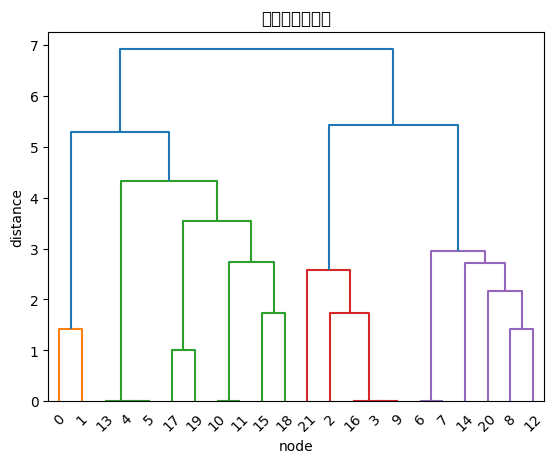

In [15]:
# 行列をグラフに変換
G = nx.DiGraph()
G.add_nodes_from(range(len(reachability_matrix)))
for i in range(len(reachability_matrix)):
    for j in range(len(reachability_matrix[i])):
        if reachability_matrix[i][j] == 1:
            G.add_edge(i, j)

# 隣接行列を対称化する
reachability_matrix = np.array(reachability_matrix)
symmetric_adjacency_matrix = np.maximum(reachability_matrix, reachability_matrix.T)

# 階層クラスタリングを実行
from scipy.cluster.hierarchy import dendrogram, linkage

# 対称な隣接行列を距離行列として使用
distances = 1 - symmetric_adjacency_matrix  # エッジの存在/非存在を距離に変換

# 階層クラスタリングを実行
linkage_matrix = linkage(distances, method='ward')

# ダンドログラムのプロット
dendrogram(linkage_matrix, labels=list(range(len(reachability_matrix))))
plt.xlabel("node")
plt.ylabel("distance")
plt.title("ダンドログラム")
plt.show()

In [16]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

c:\WorkSpace\ISM_Analysis\ISM_Analysis\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12494 (\N{KATAKANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\WorkSpace\ISM_Analysis\ISM_Analysis\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\WorkSpace\ISM_Analysis\ISM_Analysis\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 12489 (\N{KATAKANA LETTER DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\WorkSpace\ISM_Analysis\ISM_Analysis\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 36317 (\N{CJK UNIFIED IDEOGRAPH-8DDD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\WorkSpace\ISM_Analysis\ISM_Analysis\env\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 38626 (\N{CJ

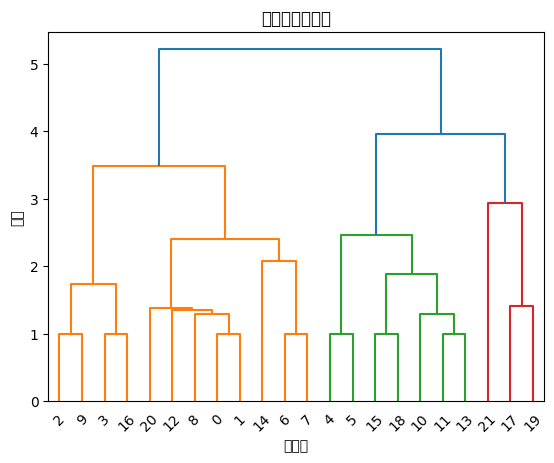

In [17]:
# 有向グラフを生成
G = nx.DiGraph()
G.add_nodes_from(range(len(reachability_matrix)))
for i in range(len(reachability_matrix)):
    for j in range(len(reachability_matrix[i])):
        if reachability_matrix[i][j] == 1:
            G.add_edge(i, j)

# 到達可能性行列を生成
reachable_matrix = np.zeros_like(reachability_matrix)
for i in range(len(reachability_matrix)):
    for j in range(len(reachability_matrix)):
        reachable_matrix[i][j] = int(nx.has_path(G, i, j))

# 階層クラスタリングを実行
linkage_matrix = linkage(reachable_matrix, method='ward')

# ダンドログラムのプロット
dendrogram(linkage_matrix, labels=list(range(len(reachability_matrix))))
plt.xlabel("ノード")
plt.ylabel("距離")
plt.title("ダンドログラム")
plt.show()

G

# 矢印の向き

In [18]:
# ISMマトリックスの生成（単純な例として、可到達行列を使って）
ism_matrix = reachability_matrix


# ISMモデルを作成（具体的なモデリングステップはドメインに依存）
print("ISMモデル:")
for i in range(len(ism_matrix)):
    for j in range(len(ism_matrix[i])):
        if ism_matrix[i][j] == 1:
            print(f"ノード {i} はノード {j} を影響します。")

ISMモデル:
ノード 0 はノード 0 を影響します。
ノード 0 はノード 1 を影響します。
ノード 1 はノード 1 を影響します。
ノード 2 はノード 0 を影響します。
ノード 2 はノード 1 を影響します。
ノード 2 はノード 2 を影響します。
ノード 3 はノード 0 を影響します。
ノード 3 はノード 1 を影響します。
ノード 3 はノード 2 を影響します。
ノード 3 はノード 3 を影響します。
ノード 3 はノード 9 を影響します。
ノード 4 はノード 0 を影響します。
ノード 4 はノード 1 を影響します。
ノード 4 はノード 4 を影響します。
ノード 4 はノード 5 を影響します。
ノード 4 はノード 10 を影響します。
ノード 4 はノード 11 を影響します。
ノード 4 はノード 13 を影響します。
ノード 5 はノード 0 を影響します。
ノード 5 はノード 1 を影響します。
ノード 5 はノード 5 を影響します。
ノード 5 はノード 10 を影響します。
ノード 5 はノード 11 を影響します。
ノード 5 はノード 13 を影響します。
ノード 6 はノード 1 を影響します。
ノード 6 はノード 6 を影響します。
ノード 6 はノード 7 を影響します。
ノード 7 はノード 1 を影響します。
ノード 7 はノード 7 を影響します。
ノード 8 はノード 0 を影響します。
ノード 8 はノード 1 を影響します。
ノード 8 はノード 8 を影響します。
ノード 9 はノード 0 を影響します。
ノード 9 はノード 1 を影響します。
ノード 9 はノード 2 を影響します。
ノード 9 はノード 9 を影響します。
ノード 10 はノード 0 を影響します。
ノード 10 はノード 1 を影響します。
ノード 10 はノード 10 を影響します。
ノード 11 はノード 0 を影響します。
ノード 11 はノード 1 を影響します。
ノード 11 はノード 10 を影響します。
ノード 11 はノード 11 を影響します。
ノード 12 はノード 0 を影響します。
ノード 12 はノード 1 を影響します。
ノード 12 はノード 12 を影響します。
ノード 13

# 影響度と関連度を考慮した場合

In [19]:
reachability_matrix.astype(int)
row = len(reachability_matrix)
print(row)

22


In [20]:
# row_sums = np.sum(reachability_matrix, axis=1)    # ISM
row_sums = np.sum(matrix, axis=1)   # dematel
# 各行の和を表示
for i, row_sum in enumerate(row_sums):
    print(f"行 {i + 1} の和: {row_sum}")

row_sums

行 1 の和: 1
行 2 の和: 0
行 3 の和: 2
行 4 の和: 2
行 5 の和: 2
行 6 の和: 3
行 7 の和: 2
行 8 の和: 1
行 9 の和: 1
行 10 の和: 1
行 11 の和: 2
行 12 の和: 3
行 13 の和: 1
行 14 の和: 4
行 15 の和: 0
行 16 の和: 4
行 17 の和: 1
行 18 の和: 5
行 19 の和: 4
行 20 の和: 5
行 21 の和: 1
行 22 の和: 5


array([1, 0, 2, 2, 2, 3, 2, 1, 1, 1, 2, 3, 1, 4, 0, 4, 1, 5, 4, 5, 1, 5])

In [21]:
# row_sums = np.sum(reachability_matrix, axis=1)    # ISM
row_sums = np.sum(matrix, axis=1)   # dematel
# 各行の和を表示
for i, row_sum in enumerate(row_sums):
    print(f"行 {i + 1} の和: {row_sum}")

row_sums

# 各列の和を計算
# column_sums = np.sum(reachability_matrix, axis=0) # ISM
column_sums = np.sum(matrix, axis=0)    # dematel

# 各列の和を表示
for j, column_sum in enumerate(column_sums):
    print(f"列 {j + 1} の和: {column_sum}")

# 関連度
d_add_r = row_sums + column_sums
d_add_r

行 1 の和: 1
行 2 の和: 0
行 3 の和: 2
行 4 の和: 2
行 5 の和: 2
行 6 の和: 3
行 7 の和: 2
行 8 の和: 1
行 9 の和: 1
行 10 の和: 1
行 11 の和: 2
行 12 の和: 3
行 13 の和: 1
行 14 の和: 4
行 15 の和: 0
行 16 の和: 4
行 17 の和: 1
行 18 の和: 5
行 19 の和: 4
行 20 の和: 5
行 21 の和: 1
行 22 の和: 5
列 1 の和: 12
列 2 の和: 14
列 3 の和: 2
列 4 の和: 1
列 5 の和: 0
列 6 の和: 1
列 7 の和: 0
列 8 の和: 1
列 9 の和: 0
列 10 の和: 2
列 11 の和: 4
列 12 の和: 2
列 13 の和: 0
列 14 の和: 2
列 15 の和: 2
列 16 の和: 0
列 17 の和: 1
列 18 の和: 0
列 19 の和: 4
列 20 の和: 1
列 21 の和: 1
列 22 の和: 0


array([13, 14,  4,  3,  2,  4,  2,  2,  1,  3,  6,  5,  1,  6,  2,  4,  2,
        5,  8,  6,  2,  5])

In [22]:
d_subtract_r = row_sums - column_sums
d_subtract_r

array([-11, -14,   0,   1,   2,   2,   2,   0,   1,  -1,  -2,   1,   1,
         2,  -2,   4,   0,   5,   0,   4,   0,   5])

In [23]:
len(d_add_r)

22

In [24]:
numbers = list(range(1, len(d_add_r)+1))

In [25]:
import japanize_matplotlib

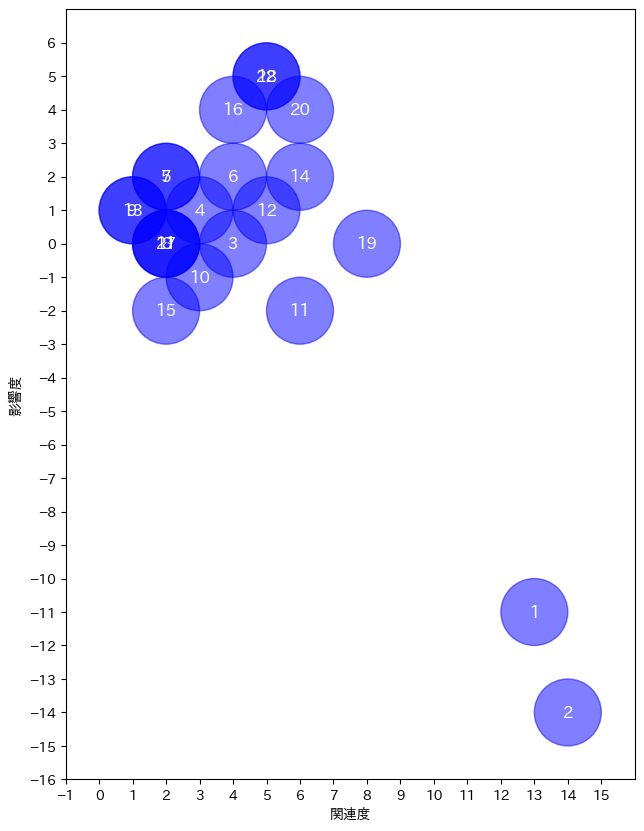

In [26]:

# 描画領域を作成する
fig, ax = plt.subplots(figsize=(10, 10))
# fig, ax = plt.subplots()

# 円を描画する
for i, (x, y, num) in enumerate(zip(d_add_r, d_subtract_r, numbers)):
    circle = plt.Circle((x, y), 1, color='blue', alpha=0.5)  # 中心座標 (x, y)、半径 0.3 の円を作成
    ax.add_patch(circle)
    ax.text(x, y, str(num), ha='center', va='center', color='white', fontsize=12)  # 中央に数字を記載

# グラフの設定
ax.set_aspect('equal')  # アスペクト比を等しくする
ax.set_xlim(min(d_add_r)-2, max(d_add_r)+2)  # x 軸の範囲を設定
ax.set_ylim(min(d_subtract_r)-2, max(d_subtract_r)+2)  # y 軸の範囲を設定
ax.set_xticks(np.arange(min(d_add_r)-2, max(d_add_r)+2))  # x 軸の目盛りを非表示にする
ax.set_yticks(np.arange(min(d_subtract_r)-2, max(d_subtract_r)+2))  # y 軸の目盛りを非表示にする
ax.set_xlabel("関連度")
ax.set_ylabel("影響度")
plt.savefig("fig/dematel_test2.png")

# グラフを表示する
plt.show()

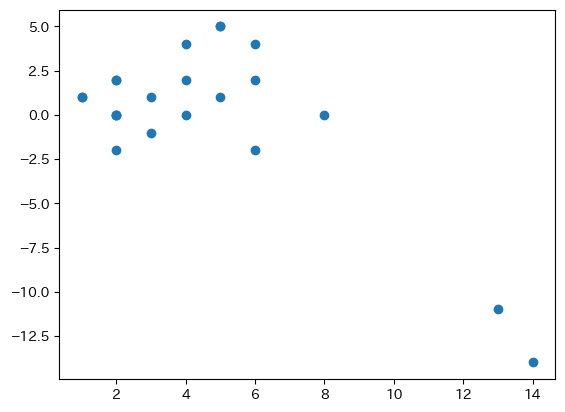

In [27]:
plt.scatter(d_add_r, d_subtract_r)

In [28]:
# 可達行列から樹形図
dendrogram(linked, orientation='top', labels=range(1, len(reachability_matrix) + 1))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Cluster Index')
plt.ylabel('Distance')
plt.show()

NameError: name 'linked' is not defined

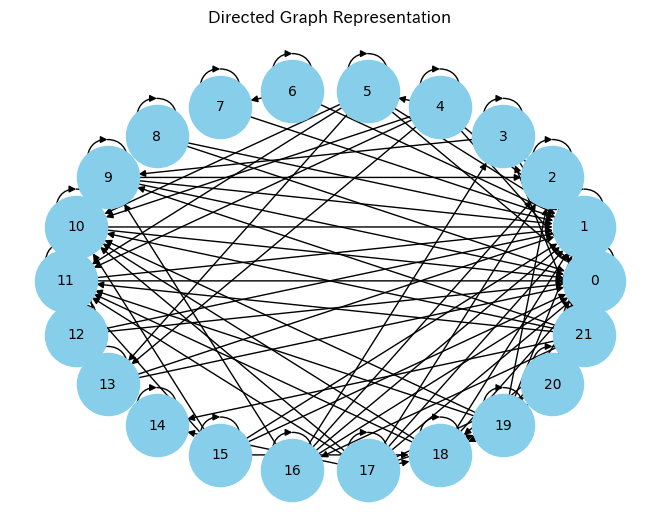

In [ ]:
# 可達行列から有向グラフ
G = nx.DiGraph(reachability_matrix)

pos = nx.circular_layout(G)  # ノードの配置方法を設定
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=10, font_color='black')
plt.title('Directed Graph Representation')
plt.show()

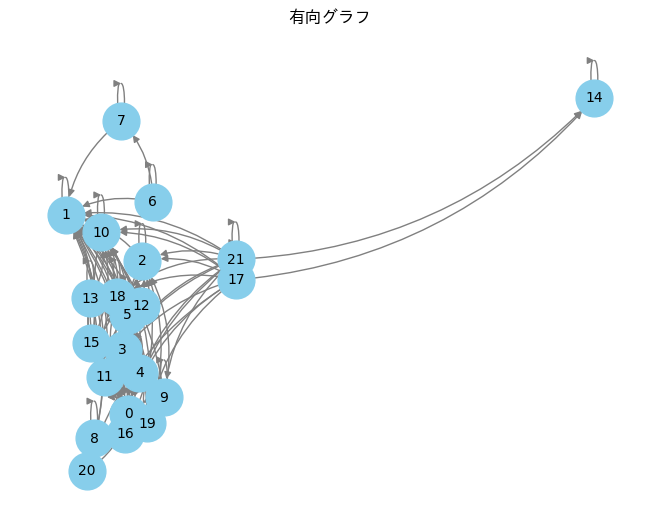

In [ ]:


# グラフオブジェクトを作成
G = nx.DiGraph()

# 可達行列の行数（および列数）を取得
num_nodes = len(reachability_matrix)

# ノードをグラフに追加
for node_id in range(num_nodes):
    G.add_node(node_id)

# エッジをグラフに追加
for i in range(num_nodes):
    for j in range(num_nodes):
        if reachability_matrix[i][j] == 1:
            G.add_edge(i, j)

# グラフを描画
pos = nx.spring_layout(G)  # グラフを描画するためのレイアウトを計算
# nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_color='black')
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_size=10, font_color='black', edge_color='gray', connectionstyle="arc3,rad=0.2")
plt.title("有向グラフ")
plt.show()

In [ ]:
# ISM機能階層分析を実行
removed_rows_dict = ism_FHA(matrix) # 肩つ行列までは求まるがエッジ作成ができない

NameError: name 'ism_FHA' is not defined

In [ ]:
# グラフを作成
G = create_graph(removed_rows_dict)

# ノードの配置を取得
pos = get_layer_positions(removed_rows_dict)

# グラフを描画して表示
plt.figure(figsize=(8, 8), dpi=600)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=15)
plt.savefig('fig\ISM-FHA_exercise.png', format='png')
plt.show()

ノードの位置を調節  
- エッジが重なって表示されているところがあるため  
- 見やすくなるようにするため  

In [ ]:
# custom_posでノード番号に対応するx座標を指定する
custom_pos = {3 : 1, 
              4 : 2,
              11: -1,
              16: 0}

# ノードの配置を取得
pos_fix = get_layer_positions(removed_rows_dict, custom_pos)

# グラフを描画して表示
plt.figure(figsize=(12, 10), dpi=600)
nx.draw(G, pos_fix, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=15)
plt.savefig('fig\ISM-FHA_exercise_fix.png', format='png')
plt.show()